## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conclusions)
- [List of References](#references)

<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [134]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [135]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [136]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [137]:
df.groupby("group").nunique().sum()

user_id         292479
timestamp       294478
group                2
landing_page         4
converted            4
dtype: int64

d. The proportion of users converted.

In [138]:
df.converted.mean()

0.11965919355605512

In [139]:
df.converted.value_counts()

0    259241
1     35237
Name: converted, dtype: int64

e. The number of times the `new_page` and `treatment` don't match.

In [140]:
df.query('group == "treatment" and landing_page != "new_page"').shape[0]

1965

In [141]:
df.query('group != "treatment" and landing_page == "new_page"').shape[0]

1928

In [142]:
1965 + 1928

3893

f. Do any of the rows have missing values?

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [144]:
# Make a copy of df
df2 = df.copy()

In [145]:
# Define the miss-matching rows 
not_match1 = df2.query('group == "treatment" and landing_page != "new_page"')
not_match2 = df2.query('group != "treatment" and landing_page == "new_page"')

In [146]:
# Drop the miss-matching rows
df2 = df2.drop(not_match1.index)
df2 = df2.drop(not_match2.index)

In [147]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [148]:
df2.groupby("group").nunique().sum()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            4
dtype: int64

b. There is one **user_id** repeated in **df2**.  What is it?

In [149]:
df2.user_id.duplicated().sum()

1

c. What is the row information for the repeat **user_id**? 

In [150]:
df2.loc[(df2.user_id.duplicated())]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [151]:
df2.user_id.drop_duplicates(inplace = True)

In [152]:
df2.user_id.duplicated().sum()

0

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [153]:
df2.head(1)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0


In [154]:
df2.converted.mean()

0.11959667567149027

b. Given that an individual was in the `control` group, what is the probability they converted?

In [155]:
df2.loc[(df2.group == "control")].converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [156]:
df2.loc[(df2.group == "treatment")].converted.mean()

0.11880724790277405

d. What is the probability that an individual received the new page?

In [157]:
df2.loc[(df2.landing_page == "new_page")].shape[0] / df2.shape[0]

0.5000636646764286

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**No. There is no strong evidence that the new treatment page leads to more conversions as the probability of conversion to the new treatment for the individuals in the treatment group is 0.1188 which is almost equal to 0.1203 for the individuals in the control group.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{old} - p_{new} \geq 0$$


  $$H_1:  p_{old} - p_{new} < 0$$


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [158]:
df2.head(1)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0


In [159]:
p_new = df2.query('converted == 1').shape[0] / df2.shape[0]
p_new

0.11959667567149027

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [160]:
p_old = df2.query('converted == 1').shape[0] / df2.shape[0]
p_old

0.11959667567149027

c. What is $n_{new}$, the number of individuals in the treatment group?

In [161]:
n_new = df2.loc[(df2.landing_page == "new_page")].user_id.nunique(0)
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [162]:
n_old = df2.loc[(df2.landing_page == "old_page")].user_id.nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [163]:
new_page_converted = np.random.choice([0, 1], size = n_new, p=[p_new, 1 - p_new])
new_page_converted 

array([1, 1, 1, ..., 1, 1, 1])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [164]:
old_page_converted = np.random.choice([0, 1], size = n_old, p=[p_old, 1 - p_old])
old_page_converted

array([1, 1, 1, ..., 1, 1, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [165]:
new_page_converted.mean() - old_page_converted.mean()


-0.0021107762273359088

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [166]:
p_diffs = []
for i in np.arange(10000):
    new_page_converted_mean = np.random.choice([0, 1], size = n_new, p = [p_new, 1 - p_new]).mean()
    old_page_converted_mean = np.random.choice([0, 1], size = n_old, p = [p_old, 1 - p_old]).mean()
    p_diffs.append(new_page_converted_mean - old_page_converted_mean)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [167]:
p_diffs = np.array(p_diffs)

(array([  1.80000000e+01,   1.93000000e+02,   9.17000000e+02,
          2.25600000e+03,   3.04000000e+03,   2.36800000e+03,
          9.57000000e+02,   2.18000000e+02,   3.00000000e+01,
          3.00000000e+00]),
 array([-0.00432044, -0.00336856, -0.00241668, -0.0014648 , -0.00051292,
         0.00043896,  0.00139084,  0.00234272,  0.0032946 ,  0.00424648,
         0.00519837]),
 <a list of 10 Patch objects>)

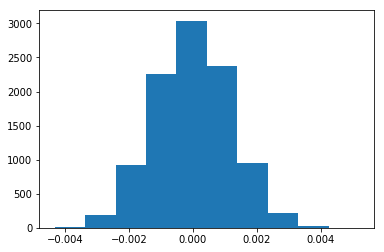

In [168]:
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [169]:
# Calculate the actual difference observed in ab_data.csv
new_page_mean = df2.loc[(df2.landing_page == "new_page")].converted.mean()
old_page_mean = df2.loc[(df2.landing_page == "old_page")].converted.mean()
observation_diff = new_page_mean - old_page_mean
observation_diff

-0.0015790565976871451

In [170]:
# Get the null values
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

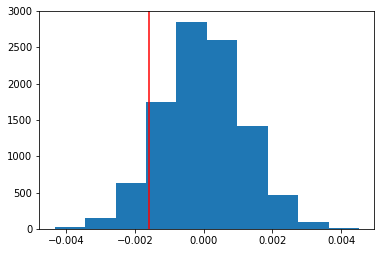

In [171]:
# Display the distribution for the null values
plt.hist(null_vals)
plt.axvline(x = observation_diff, color = 'red')

In [172]:
# Calculate the p-value
p_value = (null_vals > observation_diff).mean()
p_value

0.90800000000000003

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**It is called the p-value. And when it is greater than 0.05 it seems that we fail to reject the null hypothesis and when it is less than 0.05, we can reject the null hypothesis.
But the resulted p-value of the hypothis test confirms that we can"t reject the null hypothesis as th p-value = 0.908 which is > 0.05**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [173]:
import statsmodels.api as sm

convert_old = df2.loc[(df2.landing_page == "old_page")].converted.sum()
convert_new = df2.loc[(df2.landing_page == "new_page")].converted.sum()
n_old = df2.loc[(df2.landing_page == "old_page")].user_id.nunique()
n_new = df2.loc[(df2.landing_page == "new_page")].user_id.nunique()

convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [174]:
# Calculate the z-score and p-value using the built-in function
z_score, p_value = sm.stats.proportions_ztest(count = [convert_new, convert_old], nobs = [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

In [175]:
# Display the critical z-score values for a 95% confidence interval
import scipy.stats as st
print(st.norm.ppf(0.975))
print(st.norm.ppf(0.025))

1.95996398454
-1.95996398454


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Yes they agree with the findings in j and k. and that is because the z-score -1.311 is located between the critical z-score values when using a 95 percent confidence level which are -1.959 and 1.959 standard deviations. and by looking at the p-value which is 0.905, it is still greater than 0.05. So according to these results we fail to reject the null hypothesis**

> Reference to udersatnd about the z-score and how to get the critical z-score values for two tailed 95% confidence interval
- https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/what-is-a-z-score-what-is-a-p-value.htm
- https://stackoverflow.com/questions/20864847/probability-to-z-score-and-vice-versa

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [176]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [177]:
# Get dummy variables for the landing page and add the results of the new page to the df2
df2["ab_page"] = pd.get_dummies(df2["landing_page"])["new_page"]

In [178]:
# Add an intercept to df2
df2["intercept"] = 1

In [179]:
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [180]:
# Apply the logistic regression model to know the impact of the landing page
import statsmodels.api as sm

model = sm.Logit(df2["converted"], df2[["intercept", "ab_page"]])
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [181]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-02-12 13:49 AIC:              212780.6032
No. Observations:   290585           BIC:              212801.7625
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290583           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3116  0.1897  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

- **The p-value = 0.1897 which is greater than zero indicates that the landing page is not significant in making the decisions of conversion.**
- **The null and alternative hypothesis associated with the regression model is**

  $$H_0: p_{old} - p_{new} = 0$$


  $$H_1:  p_{old} - p_{new} != 0$$
- **The null and alternative hypothesis associated with part II**

  $$H_0: p_{old} - p_{new} \geq 0$$


  $$H_1:  p_{old} - p_{new} < 0$$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**The timestamp is included and may be it influences whether or not an individual converts. Also if the region is included, it will be a good factor to understand if it affects the conversion or not. And yes there are some disadvantages to adding additional terms into the regression model and that is when the two terms will be related to each other instead of relating to the response only, it will affect the relation to the response such as if we added the timestamp and we found  a relation between it and the landing page**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [182]:
# Read the countries.csv
df_countries = pd.read_csv("countries.csv")
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [183]:
# Join the df2 with the df_countries
df_combined = df2.set_index('user_id').join(df_countries.set_index('user_id'))

In [184]:
df_combined.head()

,timestamp,group,landing_page,converted,ab_page,intercept,country
user_id,,,,,,,
630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,US
630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,US
630002,2017-01-19 19:20:56.438330,control,old_page,0,0,1,US
630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,US
630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,US


> Reference to join 2 dataframes
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [126]:
df_combined.country.value_counts()

US    203620
UK     72466
CA     14499
Name: country, dtype: int64

In [127]:
# Get dummies for the country
dummies = pd.get_dummies(df_combined["country"])

In [128]:
# Join the dummies to the df_combined
df_combined = df_combined.join(dummies)

In [129]:
df_combined.head()

,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US
user_id,,,,,,,,,,
630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,US,0,0,1
630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,US,0,0,1
630002,2017-01-19 19:20:56.438330,control,old_page,0,0,1,US,0,0,1
630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,US,0,0,1
630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,US,0,0,1


In [130]:
# Diplay the regression model based on UK as a baseline for to know the impact of the country
import statsmodels.api as sm

model = sm.Logit(df_combined["converted"], df_combined[["intercept", "ab_page", "US", "CA"]])
result = model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366110
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-02-12 13:44 AIC:              212781.8839
No. Observations:   290587           BIC:              212824.2025
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290583           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9794    0.0127  -155.4139  0.0000  -2.0043  -1.9544
ab_page      -0.0150    0.0114    -1.3090  0.1906  -0.0374   0.0074
US           -0.0099    0.0133    -0.7446  0.4565  -0.0360   0.0162
CA           -0.0506    0.0284    -1.7835  0.0745  -0.1063   0.0050
==================================================================

"""

**From the regression model displayed above, it seems there is no impact of the country on the conversion decision as the p-vaue is greater than zero**

In [131]:
df_combined['US_ab_page'] = df_combined['US'] * df_combined['ab_page']
df_combined['CA_ab_page'] = df_combined['CA'] * df_combined['ab_page']

In [132]:
df_combined.head()

,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US,US_ab_page,CA_ab_page
user_id,,,,,,,,,,,,
630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,US,0,0,1,1,0
630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,US,0,0,1,1,0
630002,2017-01-19 19:20:56.438330,control,old_page,0,0,1,US,0,0,1,0,0
630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,US,0,0,1,1,0
630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,US,0,0,1,1,0


In [133]:
# Diplay the regression model based on UK as a baseline to know the impact of the interaction between the country and the landing page
import statsmodels.api as sm

model = sm.Logit(df_combined["converted"], df_combined[["intercept", "ab_page", "US", "CA", "US_ab_page", "CA_ab_page"]])
result = model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366106
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-02-12 13:44 AIC:              212783.4168
No. Observations:   290587           BIC:              212846.8947
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9922    0.0161  -123.4571  0.0000  -2.0238  -1.9606
ab_page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
US            0.0057    0.0188     0.3057  0.7598  -0.0311   0.0426
CA           -0.0118    0.0398    -0.2957  0.7674  -0.0899   0.0663
US_ab_page   -0.0314    0.0266    -1.1820  0.2372  -0.0836   0.0207
CA_ab_page   -0.0783    0.0568    -1.3783  0.1681  -0.1896   0.0330
==================================================================

"""

**The p-value resulted indicates that the interaction between  the country and the landing page is not significant on the conversion desicion of the individuals**

<a id='conclusions'></a>
## Conclusions

>The A/b testing for applying the new web page has shown the following
- The p-value resulted from the hypothesis test is 0.9049 which is greater than 0.05. So we fail to reject the null hypothesis 
- The p-value and z-score resulted from the built-in function confirms the findings that we fail to reject the null hypothesis
- The results from the regression model showes that the landing page, country as well as the interaction between the landing page and the country have no effect on the conversion desicion for the individuals 
- These resultes were done according to the data given which was gathered during one month (January, 2017)
- From my point of view, if the period of test was longer than one month, it could affect the hypothesis test

### Final Decision
>**According to the results of the A/B test that was performed during (January, 2017), we fail to reject the null hypothesis. Accordingly, the company should keep the old web page**

<a id='references'></a>
## List of References

> Reference to udersatnd about the z-score and how to get the critical z-score values for two tailed 95% confidence interval
- https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/what-is-a-z-score-what-is-a-p-value.htm
- https://stackoverflow.com/questions/20864847/probability-to-z-score-and-vice-versa

> Reference to join 2 dataframes
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])